# Train our own Neural Network based on Yolov3

----


## Load packages

In [28]:
import cv2
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
import datetime

from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import gc

In [2]:
print('tensorflow version:', tf.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.per_process_gpu_memory_fraction = 0.3

tensorflow version: 2.1.0


IndexError: list index out of range

In [6]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Init hyper parameters - config

In [4]:
def get_anchors(anchors):
    anchors = np.array(anchors.split(','), dtype=np.float32)
    return anchors.reshape(3, 3, 2)

NUM_CLASS = 0
ANCHORS = get_anchors('1.25,1.625, 2.0,3.75, 4.125,2.875, 1.875,3.8125, 3.875,2.8125, 3.6875,7.4375, 3.625,2.8125, 4.875,6.1875, 11.65625,10.1875')
STRIDES = np.array([8,16,32])
IOU_LOSS_THRESH = 0.3

INPUT_SIZE = 416
OUT_SIZE = [52, 26, 13]
ANCHOR_PER_SCALE = 3
MAX_BBOX_PER_SCALE = 150

## Create model

Functions to add on a `model.py` file after :)

In [5]:
import core.common as common
import core.backbone as backbone

def YOLOv3(input_layer):
    """
    """
    route_1, route_2, conv = backbone.darknet53(input_layer)

    conv = common.convolutional(conv, (1, 1, 1024,  512))
    conv = common.convolutional(conv, (3, 3,  512, 1024))
    conv = common.convolutional(conv, (1, 1, 1024,  512))
    conv = common.convolutional(conv, (3, 3,  512, 1024))
    conv = common.convolutional(conv, (1, 1, 1024,  512))

    conv_lobj_branch = common.convolutional(conv, (3, 3, 512, 1024))
    conv_lbbox = common.convolutional(conv_lobj_branch, (1, 1, 1024, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(conv, (1, 1,  512,  256))
    conv = common.upsample(conv)

    conv = tf.concat([conv, route_2], axis=-1)

    conv = common.convolutional(conv, (1, 1, 768, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))

    conv_mobj_branch = common.convolutional(conv, (3, 3, 256, 512))
    conv_mbbox = common.convolutional(conv_mobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.upsample(conv)

    conv = tf.concat([conv, route_1], axis=-1)

    conv = common.convolutional(conv, (1, 1, 384, 128))
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv = common.convolutional(conv, (1, 1, 256, 128))

    conv_sobj_branch = common.convolutional(conv, (3, 3, 128, 256))
    conv_sbbox = common.convolutional(conv_sobj_branch, (1, 1, 256, 3*(NUM_CLASS +5)), activate=False, bn=False)

    return [conv_sbbox, conv_mbbox, conv_lbbox]

def decode(conv_output, i=0):
    """
    return tensor of shape [batch_size, output_size, output_size, anchor_per_scale, 5]
            contains (x, y, w, h, score)
    """

    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]

    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy = conv_output[:, :, :, :, 0:2]
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4]
    conv_raw_conf = conv_output[:, :, :, :, 4:5]

    y = tf.tile(tf.range(output_size, dtype=tf.int32)[:, tf.newaxis], [1, output_size])
    x = tf.tile(tf.range(output_size, dtype=tf.int32)[tf.newaxis, :], [output_size, 1])

    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)

    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)

    pred_conf = tf.sigmoid(conv_raw_conf)

    return tf.concat([pred_xywh, pred_conf], axis=-1)

def load_weights(model, weights_file):
    """
    I agree that this code is very ugly, but I don’t know any better way of doing it.
    """
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    j = 0
    for i in range(75):
        conv_layer_name = 'conv2d_%d' %i if i > 0 else 'conv2d'
        bn_layer_name = 'batch_normalization_%d' %j if j > 0 else 'batch_normalization'
        conv_layer = model.get_layer(conv_layer_name)
        filters = conv_layer.filters
        k_size = conv_layer.kernel_size[0]
        in_dim = conv_layer.input_shape[-1]

        if i not in [58, 66, 74]:
            # darknet weights: [beta, gamma, mean, variance]
            bn_weights = np.fromfile(wf, dtype=np.float32, count=4 * filters)
            # tf weights: [gamma, beta, mean, variance]
            bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
            bn_layer = model.get_layer(bn_layer_name)
            j += 1
        else:
            conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)

        # darknet shape (out_dim, in_dim, height, width)
        conv_shape = (filters, in_dim, k_size, k_size)
        conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
        # tf shape (height, width, in_dim, out_dim)
        conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])

        if i not in [58, 66, 74]:
            conv_layer.set_weights([conv_weights])
            bn_layer.set_weights(bn_weights)
        else:
            w_shape = conv_weights.shape
            conv_weights = np.random.normal(0, 0.01, 1*1*w_shape[2]*15).reshape(1,1,w_shape[2],15)
            conv_bias = np.zeros(shape=conv_bias.shape)
            conv_layer.set_weights([conv_weights, conv_bias])
            
    wf.close()

In [6]:
input_tensor = tf.keras.layers.Input([416, 416, 3])
conv_tensors = YOLOv3(input_tensor)

output_tensors = []
for i, conv_tensor in enumerate(conv_tensors):
    pred_tensor = decode(conv_tensor, i)
    output_tensors.append(pred_tensor)

model = tf.keras.Model(input_tensor, output_tensors)
load_weights(model, "/data/model/yolov3.weights")

In [7]:
list_output_layer_name = ["conv2d_74", "conv2d_66", "conv2d_58"]

for i, layer in enumerate(model.layers):
    if layer.name not in list_output_layer_name:
        model.layers[i].trainable = False

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu (TensorFl [(None, 416, 416, 32 0           batch_normalization[0][0]        
______________________________________________________________________________________________

tf_op_layer_Tile_8/multiples (T [(5,)]               0           tf_op_layer_strided_slice_20[0][0
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, None, None,  0           tf_op_layer_Reshape[0][0]        
__________________________________________________________________________________________________
tf_op_layer_Tile_2 (TensorFlowO [(None, None, None,  0           tf_op_layer_strided_slice_9[0][0]
                                                                 tf_op_layer_Tile_2/multiples[0][0
__________________________________________________________________________________________________
tf_op_layer_strided_slice_3 (Te [(None, None, None,  0           tf_op_layer_Reshape[0][0]        
__________________________________________________________________________________________________
tf_op_layer_strided_slice_12 (T [(None, None, None,  0           tf_op_layer_Reshape_1[0][0]      
__________

## Load train labels

In [13]:
frames_dir = '/data/TrainSet/Drone1/Morning/Extracted-Frames-1280x720/1.1.1_renamed/'
labels_path = '/data/TrainSet/Labels/SingleActionLabels/train_labels.csv'

In [14]:
def load_labels(path):
    """ Load labels from path, removes useless boxes and keep only usefull columns
    """
    labels = pd.read_csv(path)
    labels = labels[labels['lost'] != 1]
    labels = labels[labels['occluded'] != 1]
    labels = labels[['x_min','y_min','x_max','y_max','frame','video']]
    return labels.drop_duplicates()

In [15]:
labels = load_labels(labels_path)
# optimizer = tf.keras.optimizers.Adam()

In [16]:
labels.shape

(316435, 6)

In [17]:
frames_list = os.listdir(frames_dir)
frames_list = [f for f in frames_list if '(' not in f]

frames = [frames_dir + f for f in frames_list]
# print(frames)

In [18]:
print('There are %i images in the training set'% len(frames))

There are 200 images in the training set


## Format label and image to true bboxes and image data

    image_path ==> image (416,416,3)
    bbox (xmin, ymin, xmax, ymax) ==> true_bboxes (52,52,3,5) (26,26,3,5) (13,13,3,5)

In [19]:
def get_bboxes_from_path(img_path):
    """
    """
    video, frame = img_path.split('/')[-1].split('_')
    frame = frame[:-4]
    
    bboxes = labels[(labels['video'] == video) & (
                    labels['frame'] == int(frame))]
    bboxes = bboxes[['x_min','y_min','x_max','y_max']].values
    
    return bboxes if len(bboxes) > 0 else None

def image_preprocess(image, target_size, gt_boxes=None):
    """
    """
    ih, iw    = target_size
    h,  w, _  = image.shape
    
    # Scale real image size x3
    h, w = h*3, w*3

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded, None

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes
    
def bbox_iou(boxes1, boxes2):

        boxes1 = np.array(boxes1)
        boxes2 = np.array(boxes2)

        boxes1_area = boxes1[..., 2] * boxes1[..., 3]
        boxes2_area = boxes2[..., 2] * boxes2[..., 3]

        boxes1 = np.concatenate([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                                boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
        boxes2 = np.concatenate([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                                boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

        left_up = np.maximum(boxes1[..., :2], boxes2[..., :2])
        right_down = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

        inter_section = np.maximum(right_down - left_up, 0.0)
        inter_area = inter_section[..., 0] * inter_section[..., 1]
        union_area = boxes1_area + boxes2_area - inter_area

        return inter_area / union_area
    

def preprocess_true_boxes(bboxes):
    """
    """    
    label = [np.zeros((OUT_SIZE[i], OUT_SIZE[i], ANCHOR_PER_SCALE,
                       5 + NUM_CLASS)) for i in range(3)]
    bboxes_xywh = [np.zeros((MAX_BBOX_PER_SCALE, 4)) for _ in range(3)]
    bbox_count = np.zeros((3,))

    if bboxes is not None:
        for bbox in bboxes:
            bbox_coor = bbox[:4]

            bbox_xywh = np.concatenate([(bbox_coor[2:] + bbox_coor[:2]) * 0.5, bbox_coor[2:] - bbox_coor[:2]], axis=-1)
            bbox_xywh_scaled = 1.0 * bbox_xywh[np.newaxis, :] / STRIDES[:, np.newaxis]

            iou = []
            exist_positive = False
            for i in range(3):
                anchors_xywh = np.zeros((ANCHOR_PER_SCALE, 4))
                anchors_xywh[:, 0:2] = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                anchors_xywh[:, 2:4] = ANCHORS[i]

                iou_scale = bbox_iou(bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh)
                iou.append(iou_scale)
                iou_mask = iou_scale > 0.3

                if np.any(iou_mask):
                    xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32)

                    label[i][yind, xind, iou_mask, :] = 0
                    label[i][yind, xind, iou_mask, 0:4] = bbox_xywh
                    label[i][yind, xind, iou_mask, 4:5] = 1.0

                    bbox_ind = int(bbox_count[i] % MAX_BBOX_PER_SCALE)
                    bboxes_xywh[i][bbox_ind, :4] = bbox_xywh
                    bbox_count[i] += 1

                    exist_positive = True

            if not exist_positive:
                best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                best_detect = int(best_anchor_ind / ANCHOR_PER_SCALE)
                best_anchor = int(best_anchor_ind % ANCHOR_PER_SCALE)
                xind, yind = np.floor(bbox_xywh_scaled[best_detect, 0:2]).astype(np.int32)

                label[best_detect][yind, xind, best_anchor, :] = 0
                label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
                label[best_detect][yind, xind, best_anchor, 4:5] = 1.0

                bbox_ind = int(bbox_count[best_detect] % MAX_BBOX_PER_SCALE)
                bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
                bbox_count[best_detect] += 1

    label_sbbox, label_mbbox, label_lbbox = label

    batch_smaller_target = label_sbbox
    batch_medium_target  = label_mbbox
    batch_larger_target  = label_lbbox

    return batch_smaller_target, batch_medium_target, batch_larger_target


def get_one_img_true_bboxes(img_path):
    """
    """    
    bboxes = get_bboxes_from_path(img_path)
    image = cv2.imread(img_path)
    
    image, bboxes = image_preprocess(np.copy(image), [INPUT_SIZE, INPUT_SIZE], bboxes)
    
    smaller_target, medium_target, larger_target = preprocess_true_boxes(bboxes)
    
    gc.collect()

    return image, (smaller_target, medium_target, larger_target)

## Prepare loss function

**XY_LOSS** :

$ \lambda_{\text{coord}} \sum_{i=0}^{S^2} \sum_{j=0}^{B} p_{ij}^{obj} (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2$

In [20]:
def bbox_giou(boxes1, boxes2):
    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., 2:]),
                        tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
    boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., 2:]),
                        tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)

    boxes2 = tf.cast(boxes2, dtype=tf.float32)
    
    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    
    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    
    union_area = boxes1_area + boxes2_area - inter_area
    iou = inter_area / union_area

    enclose_left_up = tf.minimum(boxes1[..., :2], boxes2[..., :2])
    enclose_right_down = tf.maximum(boxes1[..., 2:], boxes2[..., 2:])
    enclose = tf.maximum(enclose_right_down - enclose_left_up, 0.0)
    enclose_area = enclose[..., 0] * enclose[..., 1]
    giou = iou - 1.0 * (enclose_area - union_area) / enclose_area

    return giou

def custom_loss(y_true, y_pred):
    """
    """
    pred_conf     = y_pred[..., 4:5]
    true_conf     = y_true[..., 4:5]
    
    pred_xy       = y_pred[..., 0:2]
    true_xy       = y_true[..., 0:2]
    
    pred_wh       = y_pred[..., 2:4]
    true_wh       = y_true[..., 2:4]
    
    conf_loss = tf.keras.losses.binary_crossentropy(true_conf, pred_conf)
    xy_loss   = tf.reduce_sum(tf.reduce_sum(tf.square(true_xy - pred_xy)*true_conf, axis=-1), axis=-1)
    wh_loss   = tf.reduce_sum(tf.reduce_sum(tf.square(tf.sqrt(true_wh) - tf.sqrt(pred_wh))*true_conf, axis=-1), axis=-1)

    intersect_wh = K.maximum(K.zeros_like(pred_wh), (pred_wh + true_wh)/2 - K.abs(pred_xy - true_xy) )
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
    true_area = true_wh[...,0] * true_wh[...,1]
    pred_area = pred_wh[...,0] * pred_wh[...,1]
    union_area = pred_area + true_area - intersect_area
    iou = intersect_area / union_area
    
    iou_loss = K.sum(K.square(true_conf[...,0]*iou - pred_conf[...,0])*true_conf[...,0], axis=-1) 
    
    conf_loss = K.sum(conf_loss)
    xy_loss   = K.sum(xy_loss)
    wh_loss   = K.sum(wh_loss)
    
    xy_loss    = tf.where(tf.math.is_nan(xy_loss), tf.constant(10000., dtype=tf.float32), xy_loss)
    wh_loss    = tf.where(tf.math.is_nan(wh_loss), tf.constant(10000., dtype=tf.float32), wh_loss)
    iou_loss   = tf.where(tf.math.is_nan(iou_loss), tf.constant(10000., dtype=tf.float32), iou_loss)
    
    loss = conf_loss + xy_loss + wh_loss + iou_loss
    
    return loss

In [21]:
# Choose optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile model
model.compile(optimizer=optimizer, loss=custom_loss)

## TRAIN !! :D

In [40]:
def load_batch_data(frames):
    """
    """
    n_batch = len(frames)

    Y_true = [np.zeros((n_batch, OUT_SIZE[i], OUT_SIZE[i], 3, 5+NUM_CLASS)) for i in range(3)]
    X = np.zeros(shape=(n_batch, INPUT_SIZE, INPUT_SIZE, 3), dtype=np.float32)

        
    for b in range(n_batch):
        if i == 0:
            np.random.shuffle(frames)
        image_data, image_target = get_one_img_true_bboxes(frames[b])

        X[b] = image_data

        for k in range(len(image_target)):
            Y_true[k][b] = image_target[k]

        gc.collect()
    
    return X, Y_true
    
    
def train_batch(frames, n_epoch=1, batch_size=4, val_split=0.1):
    """
    """
    n = len(frames)
    t0 = time.time()
    
    n_steps = int(n/batch_size)+1
    train_scores = list()
    valid_scores = list()
    
    for i in tqdm(range(n_steps)):
        start = i*batch_size
        end   = (i+1)*batch_size if i < n_steps-1 else n
        
        n_frames = end-start
    
        if n_frames == 0:
            break
        
        num_val   = int(n_frames * val_split)
        num_train = n_frames - num_val 
        
        
        X_train, Y_train = load_batch_data(frames[start:start+num_train])
        X_valid, Y_valid = load_batch_data(frames[start+num_train:end])
        
        model.train_on_batch(X_train, Y_train, reset_metrics=False)
        train_scores.append(model.evaluate(X_train, Y_train, verbose=0))
        if num_val > 0:
            valid_scores.append(model.evaluate(X_valid, Y_valid, verbose=0))
        
    train_scores = np.mean(train_scores, axis=0)
    valid_scores = np.mean(valid_scores, axis=0)

    with writer.as_default():
        tf.summary.scalar(name="loss1", data=train_scores[1], step=n_epoch)
        tf.summary.scalar(name="loss2", data=train_scores[2], step=n_epoch)
        tf.summary.scalar(name="loss3", data=train_scores[3], step=n_epoch)
        writer.flush()

    with writer_valid.as_default():
        tf.summary.scalar(name="loss1", data=valid_scores[1], step=n_epoch)
        tf.summary.scalar(name="loss2", data=valid_scores[2], step=n_epoch)
        tf.summary.scalar(name="loss3", data=valid_scores[3], step=n_epoch)
        writer_valid.flush()
    
    tf.print('-----------------------------------')
    tf.print('epoch n°%i finished'%n_epoch) 
    
    tf.print("TRAIN SET : epoch scores: losses = %s "%(' '.join([str(s) for s in train_scores])))
    if type(valid_scores) == list:
        tf.print("VALID SET : epoch scores: \n losses = %s "%(' '.join([str(s) for s in valid_scores])))
    
def fit(frames, epochs=1, batch_size=10, val_split=0.1):
    """
    """
    np.random.shuffle(frames)
    print('Train on %i frames on one epoch, Validation on %i frames, BS = %i'%(
            len(frames)-int(len(frames)*val_split), int(len(frames)*val_split), batch_size))
    
    for e in range(epochs):
        train_batch(frames, e+1, batch_size, val_split)
        
    
    tf.print('-----------------------------------')
    tf.print('Training ended ! :)')

In [42]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# before training init writer (for tensorboard log) / model
writer = tf.summary.create_file_writer(log_dir+'/train')
writer_valid = tf.summary.create_file_writer(log_dir+'/valid')

In [ ]:
# %tensorboard --logdir logs/fit --bind_all

In [43]:
fit(frames[:50], epochs=5, batch_size=10, val_split=0.2)

  0%|          | 0/6 [00:00<?, ?it/s]

Train on 40 frames on one epoch, Validation on 10 frames, BS = 10


 83%|████████▎ | 5/6 [01:21<00:16, 16.36s/it]

(4,)
-----------------------------------
epoch n°1 finished
TRAIN SET : epoch scores: losses = nan nan nan 9.52805004119873 



 83%|████████▎ | 5/6 [01:40<00:20, 20.00s/it]

(4,)
-----------------------------------
epoch n°2 finished
TRAIN SET : epoch scores: losses = nan nan nan 8.374080085754395 



 83%|████████▎ | 5/6 [01:25<00:17, 17.02s/it]

(4,)
-----------------------------------
epoch n°3 finished
TRAIN SET : epoch scores: losses = nan nan nan 7.621699428558349 



 83%|████████▎ | 5/6 [01:21<00:16, 16.33s/it]

(4,)
-----------------------------------
epoch n°4 finished
TRAIN SET : epoch scores: losses = nan nan nan 7.095043277740478 



 83%|████████▎ | 5/6 [01:28<00:17, 17.63s/it]

(4,)
-----------------------------------
epoch n°5 finished
TRAIN SET : epoch scores: losses = nan nan nan 6.7009564399719235 
-----------------------------------
Training ended ! :)


## Predict on one image

In [26]:
def draw_bbox(image, bboxes, show_label=True):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """

    image_h, image_w, _ = image.shape
    colors = [255]

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        bbox_color = colors[0]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % ('person', score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick//2)[0]
            cv2.rectangle(image, c1, (c1[0] + t_size[0], c1[1] - t_size[1] - 3), bbox_color, -1)  # filled

            cv2.putText(image, bbox_mess, (c1[0], c1[1]-2), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)

    return image

def bboxes_iou(boxes1, boxes2):

    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)
    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]

        while len(cls_bboxes) > 0:
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

def postprocess_boxes(pred_bbox, org_img_shape, input_size, score_threshold):

    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    # pred_prob = pred_bbox[:, 5:]

    # # (1) (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # # (2) (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = org_img_shape
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # # (3) clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # # (4) discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # # (5) discard some boxes with low scores
    # classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf # * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], np.full((sum(mask)),1)
    

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

def predict_on_frame(frame, input_size=416):
    """
    """
    # Preprocess image (change size and convert to np array)
    frame_size = frame.shape[:2]
    image_data, _ = image_preprocess(np.copy(frame), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    
    gc.collect()

    # Predict using keras model
    pred_bbox = model.predict_on_batch(image_data)
    
    del image_data
    gc.collect()

    # Post process boxes to so that they can be draw on image
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    bboxes = postprocess_boxes(pred_bbox, frame_size, input_size, 0.01)
    bboxes = nms(bboxes, 0.45, method='nms')
    
    # Draw box on image
    image = draw_bbox(frame, bboxes)
    
    del frame, pred_bbox
    gc.collect()

    # Convert image to np array
    result = np.asarray(image)
    
    # Add an information at the top of the image
    info = 'no object' if len(bboxes) < 1 else 'object detected'
    cv2.putText(result, text=info, org=(50, 70), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=2, color=(255, 255, 255), thickness=5)
    
    result = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    del bboxes, image
    gc.collect()
    
    if cv2.waitKey(1) & 0xFF == ord('q'): return None
    return result

In [27]:
image_path = frames[52]
frame = cv2.imread(image_path)
out = predict_on_frame(frame)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in less


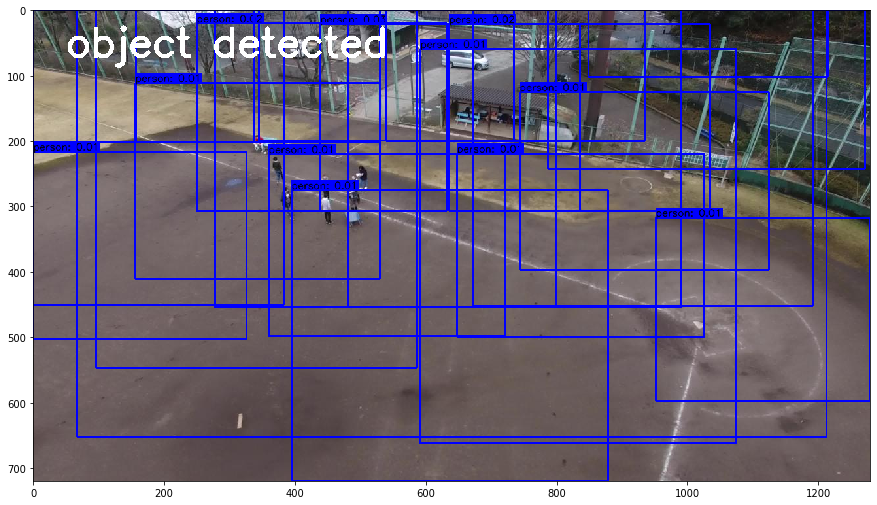

In [28]:
fig, ax = plt.subplots(figsize=(15,22))
plt.imshow(out)
plt.show()